In [1]:
import importlib.util
if importlib.util.find_spec('pvlib') is None:
    !pip install pvlib


# Tutorial 4 - Modelación módulo PV

Este es un tutorial para estimar el desempeño de un módulo PV usando `pvlib`.

In [2]:
import pvlib

Acá utilizaremos 3 módulos de la librería.

- `pvlib.irradiance`: para estimación de ángulos de incidencia y niveles de irradiación efectivos sobre el módulo.
- `pvlib.temperature`: para estimación de la temperatura de las celdas en condiciones de operación.
- `pvlib.pvsystem`: para análisis de módulos pv y estimación de curvas IV.

> Para mayor información de las funciones de este tutorial, revisar la documentación oficial de [`pvlib`](https://pvlib-python.readthedocs.io/en/stable/reference/index.html)

## Selección de módulo pv (`pvsystem.retrieve_sam`)

### La biblioteca de módulos CEC (`'CECmod'`)

El *California Energy Commission Comisión* (CEC) contrató laboratorios de pruebas autorizados para caracterizar una variedad de módulos pv en condiciones de medición estandar (*standard test conditions* o STC). Los resultados incluyen: corriente en corto circuito ($I_\mathrm{sc}$), voltaje en circuito abierto ($V_\mathrm{oc}$); voltaje, corriente y potencia en punto de potencia máxima o mpp ($V_\mathrm{mpp}$,  $I_\mathrm{mpp}$ y $P_\mathrm{mpp}$); coeficientes de temperatura de voltaje y corriente, dimensiones del módulo, número de celdas en serie ($N_s$), subcadenas paralelas ($N_p$), área del módulo en $\mathrm{m^2}$ ($A_c$), entre otros. La base de datos CEC está disponibles en la [Lista de equipos solares](https://solarequipment.energy.ca.gov/Home/PVModuleList) y en un archivo CSV incluido en el *System Advisor Model* (SAM) del *National Renewable Energy Laboratory* (NREL).

En `pvlib` podemos acceder a la biblioteca CEC mediante la función `retrieve_sam` del módulo `pvlib.pvsystem`, usando el argumento `name = 'CECMod'`

In [3]:
pv_module_db = pvlib.pvsystem.retrieve_sam(name = 'CECMod')

La información está desplegada en formato *dataframe*, donde los modelos de paneles están en anexados por columnas.

In [4]:
pv_module_db.T.head() # Trasponemos la lista con ".T", para visualizar los paneles por filas

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
A10Green_Technology_A10J_S72_175,Mono-c-Si,0,175.0914,151.2,1.3,1.576,0.825,72,5.17,43.99,...,1.981696,5.175703,0.0,0.316688,287.102203,16.057121,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_180,Mono-c-Si,0,179.928,155.7,1.3,1.576,0.825,72,5.31,44.06,...,1.988414,5.316148,0.0,0.299919,259.047943,16.418983,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_185,Mono-c-Si,0,184.7016,160.2,1.3,1.576,0.825,72,5.43,44.14,...,1.984817,5.435676,0.0,0.311962,298.424438,15.688233,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_220,Multi-c-Si,0,219.876,189.1,1.624,1.632,0.995,60,7.95,36.06,...,1.673094,7.959062,0.0,0.140393,123.168404,21.875164,-0.5196,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_225,Multi-c-Si,0,224.9856,193.5,1.624,1.632,0.995,60,8.04,36.24,...,1.671782,8.047206,0.0,0.14737,164.419479,20.698376,-0.5196,N,SAM 2018.11.11 r2,1/3/2019


Cada módulo está caracterizado por los siguientes parámetros:

| parámetro    | tipo de variable | Unidades o descripción                                                                         |
| :----------- | :--------: | :-------------------------------------------------------------------------------------------- |
| `Technology` | string    | one of "Mono-c-Si", "Multi-c-Si", "Thin Film", "CdTe", or "CIGS" families of cells            |
| `Bifacial`   | boolean   | is bifacial?                                                                                  |
| `STC`        | float     | nameplate in W at STC                                                                         |
| `PTC`        | float     | nameplate in W at PVUSA test conditions (1-sun, 20&deg; ambient temperature, 1-m/s windspeed) |
| `A_c`        | float     | module area in m&sup2;                                                                        |
| `Length`     | float     | module length in m;                                                                           |
| `Width`      | float     | module width in m;                                                                            |
| `N_s`        | int       | number of cells in series                                                                     |
| `I_sc_ref`   | float     | short circuit current in A at reference condition                                             |
| `V_oc_ref`   | float     | open circuit voltage in V at reference condition                                              |
| `I_mp_ref`   | float     | max power current in A at reference condition                                                 |
| `V_mp_ref`   | float     | max power voltage in V at reference condition                                                 |
| `alpha_sc`   | float     | short circuit current temperature coefficient in A/&Delta;&deg;C                              |
| `beta_oc`    | float     | open circuit voltage temperature coefficient in V/&Delta;&deg;C                               |
| `T_NOCT`     | float     | normal operating cell temperature in &deg;C                                                   |
| `a_ref`      | float     | diode ideality factor                                                                         |
| `I_L_ref`    | float     | light or photogenerated current at reference condition in A                                   |
| `I_o_ref`    | float     | diode saturation current at reference condition in A                                          |
| `R_s`        | float     | series resistance in &Omega;                                                                  |
| `R_sh_ref`   | float     | shunt resistance at reference condition in &Omega;                                            |
| `Adjust`     | float     | adjustment to short circuit temperature coefficient in %                                      |
| `gamma_r`    | float     | power temperature coefficient at reference condition in %/&Delta;&deg;C                       |
| `BIPV`       | boolean   | is building integrated PV?                                                                    |

### Selección de modelo de panel

Como vemos, en la biblioteca CEC los módulos se nombran según el esquema 

    <nombre del fabricante><modelo>
Los espacios en blanco, los guiones y otros caracteres no alfanuméricos se reemplazan por `_` en pvlib python. Por ejemplo, “Canadian Solar Inc. CS5M-220M” existe en la base de datos como: `Canadiense_Solar_Inc__CS5P_220M`

Alternativamente, podemos usar el comando `.T.index.str.startswith` para buscar el modelo. Por ejemplo, para buscar e modelo [CS6X-300M de Canadian Solar Inc](https://s3.amazonaws.com/ecodirect_docs/CANADIAN/MaxPower_CS6X-M.pdf), buscamos todos los modelos cuyo nombre incluye `'Canadian_Solar_Inc__CS6X'`

In [5]:
pv_module_index = pv_module_db.T.index.str.startswith('Canadian_Solar_Inc__CS6X')
pv_module_db.T[pv_module_index]

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
Canadian_Solar_Inc__CS6X_255M,Mono-c-Si,0,255.2,226.9,1.852,1.931,0.959,72,7.83,44.0,...,1.897111,7.846079,0.0,0.456126,222.113968,41.39444,-0.4697,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6X_255P,Multi-c-Si,0,255.084,226.3,1.852,1.931,0.959,72,7.95,43.7,...,1.998586,7.966794,0.0,0.440573,208.55162,10.336473,-0.53,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6X_260M,Mono-c-Si,0,260.161,231.4,1.852,1.931,0.959,72,7.92,44.1,...,1.896924,7.932119,0.0,0.449034,293.451385,40.807045,-0.4697,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6X_260P,Multi-c-Si,0,260.005,230.8,1.852,1.931,0.959,72,8.04,43.8,...,1.997587,8.052831,0.0,0.434024,271.963593,9.824679,-0.53,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6X_265M,Mono-c-Si,0,265.185,236.0,1.852,1.931,0.959,72,7.98,44.3,...,1.900692,7.987295,0.0,0.441648,483.153839,40.182526,-0.4697,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6X_265P,Multi-c-Si,0,265.005,235.4,1.852,1.931,0.959,72,8.1,43.9,...,1.999095,8.107948,0.0,0.413359,421.288391,9.56615,-0.53,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6X_270M,Mono-c-Si,0,269.848,240.6,1.852,1.931,0.959,72,8.07,44.4,...,1.902148,8.074576,0.0,0.43477,766.684692,39.816162,-0.4697,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6X_270P,Multi-c-Si,0,270.045,240.0,1.852,1.931,0.959,72,8.19,44.1,...,2.007003,8.196337,0.0,0.404672,522.96991,9.463469,-0.53,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6X_275M,Mono-c-Si,0,274.944,245.2,1.852,1.931,0.959,72,8.19,44.5,...,1.911487,8.196024,0.0,0.410853,558.503357,40.504654,-0.4697,N,SAM 2018.11.11 r2,1/3/2019
Canadian_Solar_Inc__CS6X_275P,Multi-c-Si,0,275.48,244.6,1.852,1.931,0.959,72,8.31,44.1,...,2.014461,8.316535,0.0,0.367813,467.746704,10.188554,-0.53,N,SAM 2018.11.11 r2,1/3/2019


De aquí identificamos que el modelo está bajo el nombre `Canadian_Solar_Inc__CS6X_300M`

In [6]:
pv_model = pv_module_db.Canadian_Solar_Inc__CS6X_300M

Los parámetros CEC de este módulo son

In [7]:
pv_model

Technology            Mono-c-Si
Bifacial                      0
STC                      300.03
PTC                       273.6
A_c                       1.852
Length                    1.931
Width                     0.959
N_s                          72
I_sc_ref                   8.74
V_oc_ref                   45.0
I_mp_ref                   8.22
V_mp_ref                   36.5
alpha_sc               0.004326
beta_oc                -0.15372
T_NOCT                     44.3
a_ref                  1.861184
I_L_ref                8.745869
I_o_ref                     0.0
R_s                    0.366101
R_sh_ref             545.178589
Adjust                 4.722239
gamma_r                  -0.442
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS6X_300M, dtype: object

## Simulación de curva IV

Para simular la curva IV de un módulo debemos considerar los siguientes pasos:
- Definir las condiciones de operación (niveles de irradiancia y condiciones climatológicas del sitio)
- Determinar irradiación sobre el módulo
- Determinar la temperatura de las celdas dentro del módulo
- Determinar los [cinco parámetros del SDM](../../10_SolarFotovoltaica/10_SolarFotovoltaica.ipynb) para los niveles de irradiancia y temperatura de la celda.
- Caracterizar la curva IV en las condiciones de operación.
- Graficar curva IV según condiciones de operación.

### Condiciones de operación

En este caso consideraremos un panel solar con ángulos de inclinación $\theta = 30°$ y $\phi = 90°$.

In [8]:
pv_module_zenith  = 30 # ángulo cenital
pv_module_azimuth = 90 # ángulo acimutal

Respecto a las condiciones climáticas y de irradiación, consideraremos la siguiente serie de datos.

In [9]:
import pandas as pd

site_conditions = pd.DataFrame(data = {
            'ghi': [  450,   550,   950,  1050],  # Irradiación horizontal global (W/m2)
            'dni': [  170,   130,   950,   960],  # Irradiación normal directa (W/m2)
            'dhi': [  350,   430,   100,   100],  # Irradiación horizonal difusa (W/m2)
'apparent_zenith': [ 44.2,  33.1,  23.3,  17.4],  # ángulo cenital aparente (°)
        'azimuth': [ 97.4, 110.6, 131.3, 167.9],  # ángulo acimutal (°)
       'temp_air': [ 13.0,  13.5,  15.0,  16.5],  # temperatura del aire (°V)
     'wind_speed': [  6.5,   7.2,   7.6,  8.05]}) # Velocidad del viento (m/s)

site_conditions

,ghi,dni,dhi,apparent_zenith,azimuth,temp_air,wind_speed
0,450,170,350,44.2,97.4,13.0,6.50
1,550,130,430,33.1,110.6,13.5,7.20
2,950,950,100,23.3,131.3,15.0,7.60
3,1050,960,100,17.4,167.9,16.5,8.05


En este caso, agrupamos todos los datos en un *dataframe* `site_conditions` para facilitar la manipulación posterior. Sin embargo, esto no es obligatorio.

### Irradiación sobre el módulo (`pvlib.irradiance`)

La irradiación efectiva sobre la superficie del módulo ($G_\mathrm{eff}$), depende del **ángulo de incidencia ($\theta_i$)** y los **niveles de irradiación (GHI, DNI y DHI)**. En general, determinar esto requiere de modelos complejos. Acá, para simplificar, usaremos la relación:

\begin{equation*}
G_\mathrm{eff} = G_\mathrm{DNI}\cos\theta_i + G_\mathrm{DHI}
\end{equation*}

Para determinar el **ángulo de incidencia (*angle of incidence* o AOI)**, usamos la función `aoi` del módulo `pvlib.irradiance`. Tal como se discutió en la [unidad 7](../../07_Radiación_Solar/07_Radiación_Solar.ipynb), el ángulo de incidencia depende de los ángulos de inclinación del módulo y del sol. En la función `aoi`, estos parámetros son:

- `surface_tilt`: ángulo cenital del módulo (en grados)
- `surface_azimuth`: ángulo acimutal del módulo (en grados)
- `solar_zenith`: ángulo cenital solar (en grados)
- `solar_azimuth`: ángulo acimutal solar (en grados)

In [10]:
sun_zenith  = site_conditions['apparent_zenith'].values
sun_azimuth = site_conditions['azimuth'].values

aoi = pvlib.irradiance.aoi(
    surface_tilt    = pv_module_zenith,
    surface_azimuth = pv_module_azimuth,
    solar_zenith    = sun_zenith,
    solar_azimuth   = sun_azimuth)

In [11]:
aoi # mostramos el ángulo de incidencia

array([14.86296973, 11.16380436, 19.26937607, 30.93638479])

Con esto, determinamos la irradiación efectiva sobre el módulo.

In [12]:
import numpy as np

# get irradiance
dni = site_conditions['dni'].values
ghi = site_conditions['ghi'].values
dhi = site_conditions['dhi'].values

# Determinamos irradiación effectiva sobre el módulo
Geff = dni*np.cos(np.radians(aoi)) + dhi

print('Irradiación efectiva:', Geff)

Irradiación efectiva: [514.31215061 557.5400963  996.77859924 923.42907172]


### Temperatura de las celdas (`pvlib.temperature`)

Existen distintos modelos para determinar la temperatura de las celdas $T_\mathrm{cell}$. En este curso usaremos el [*Sandia Array Performance Model*](https://www.osti.gov/servlets/purl/919131) de *Sandia National Laboratories*. El modelo está compuesto por dos ecuaciones:

\begin{align*}
T_\mathrm{mod} &= G_\mathrm{eff} e^{a + b V_\mathrm{wind}} + T_a \\
T_\mathrm{cell} &= T_\mathrm{mod} + \frac{G_\mathrm{eff}}{G_0}\Delta T
\end{align*}

donde $T_a$ es la temperatura del aire, $G_\mathrm{eff}$ es la irradiancia efectiva sobre el módulo, $G_0$ es la irradiancia de referencia, $V_\mathrm{wind}$ es la velocidad del viento, $T_\mathrm{mod}$ es la temperatura del módulo, y $a$, $b$ y $\Delta T$ son parámetros de ajuste.

Este modelo está implementado en la función `sapm_cell` del módulo `pvlib.temperature`. La función requiere de los siguientes parámetros:
- `poa_global`: Irradiación efectiva sobre el módulo ($\mathrm{W/m^2}$)
- `temp_air`: Temperatura del aire (°C)
- `wind_speed`: Velocidad del viento (m/s)
- `a`: Parámetro $a$.
- `b`: Parámetro $b$.
- `deltaT`: Parámetro $\Delta T$.
- `irrad_ref`: Irradiancia de referencia, $E_0$ ($\mathrm{W/m^2}$). `irrad_ref = 1000`, por defecto).


Los parámetros de ajuste $a$, $b$ y $\Delta T$ dependen, en general, de la construcción del módulo pv (protección frontal y trasera) y de su montaje. La variable `TEMPERATURE_MODEL_PARAMETERS` del módulo `pvlib.temperature` contiene una lista de referencia:

| front / backsheet | montaje | variable |
|:--------------------:|:-------:|:--------:|
|vidrio / vidrio|rack abierto|`open_rack_glass_glass`|
|vidrio / vidrio|rack cerrado|`close_mount_glass_glass`|
|vidrio / polímero|rack abierto|`open_rack_glass_polymer`|
|vidrio / polímero|rack aislado|`insulated_glass_polymer`|

In [13]:
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
TEMPERATURE_MODEL_PARAMETERS['sapm']

{'open_rack_glass_glass': {'a': -3.47, 'b': -0.0594, 'deltaT': 3},
 'close_mount_glass_glass': {'a': -2.98, 'b': -0.0471, 'deltaT': 1},
 'open_rack_glass_polymer': {'a': -3.56, 'b': -0.075, 'deltaT': 3},
 'insulated_back_glass_polymer': {'a': -2.81, 'b': -0.0455, 'deltaT': 0}}

En este caso, consideraremos los parámetros de un módulo sin aislar y protegido por un polímero en la parte trasera (`open_rack_glass_polymer`); adecuado para la mayoría de los sistemas actuales.

In [14]:
parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']

Ahora procedemos a determinar la temperatura de la celda.

> **Nota:** usamos el argumento `**parameters` para extraer los parámetros `a`, `b` y `deltaT` de forma automática. Omitimos el parámetro `irrad_ref` para usar el valor por defecto.

In [15]:
# Extraemos datos de temperatura del aire y viento
temp_air = site_conditions['temp_air'].values
wind_speed = site_conditions['wind_speed'].values

# Calculamos la temperatura de la celda
temp_cell = pvlib.temperature.sapm_cell(   
    poa_global = Geff,
    temp_air   = temp_air,
    wind_speed = wind_speed,
    **parameters)

print('Temperatura de la celda: ', temp_cell)

Temperatura de la celda:  [23.52590479 24.41255133 34.02140522 33.62881438]


### Parámetros SDM en operación (`pvlib.pvsystem.calcparams_cec`)

[Como vimos en la unidad 10](../../10_SolarFotovoltaica/10_SolarFotovoltaica.ipynb), el modelo SDM está caracterizado por 5 parámetros:
- Corriente fotoinducida, `IL` (análogo a $I_\mathrm{ph}$)
- Corriente de saturación, `I0`.
- Resistencia en derivación, `Rs`.
- Resistencia en serie, `Rsh`.
- Factor de idealidad del diodo, $n$.

Es importante considerar que **los parámetros de la biblioteca CEC fueron determinados en condiciones de operación estandar  (o STC)**. Así, debemos **determinar el valor efectivo de estos parámetros en las condiciones de operación del módulo pv.**

**En `pvlib` usamos la función `calcparams_cec` del módulo `pvlib.pvsystem` para derterminar `IL`, `I0`, `Rs`, `Rsh` y `nNsVth` en las condiciones de operación.** El último parámetro (`nNsVth`), corresponde al producto entre $n$, el número de celdas en serie ($N_s$) y el voltaje térmico ($V_T$).

Como parámetros de entrada, `pvsystem.calcparams_cec` requiere: 
- `effective_irradiance`: Niveles de irradiancia
- `temp_cell`: Temperatura de la celda
- `alpha_sc`, `a_ref`, `I_L_ref`, `I_o_ref`, `R_sh_ref` y `Adjust`: Parámetros CEC asociados al módulo seleccionado.
- `EgRef`: Bandgap de la celda (`EgRef = 1.121` en todos los casos)
- `dEgdT`: Variación del bandgap con la temperatura (`dEgdT = -0.0002677` en todos los casos)

In [16]:
IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_cec(
        effective_irradiance = Geff,
        temp_cell = temp_cell,
        alpha_sc = pv_model.alpha_sc,
        a_ref    = pv_model.a_ref,
        I_L_ref  = pv_model.I_L_ref,
        I_o_ref  = pv_model.I_o_ref,
        R_sh_ref = pv_model.R_sh_ref,
        R_s      = pv_model.R_s,
        Adjust   = pv_model.Adjust,
        EgRef    = 1.121,
        dEgdT    = -0.0002677)

El resultado de cada variable se almacena en un arreglo asociado a las condiciones de irradiación y temperatura.

In [17]:
# Mostramos resultado en formato dataframe (solo para visualización)
column_values = ['Geff (W/m2)', 'Tcell (°C)', 'IL (A)', 'I0 (A)', 'Rs (Ohm)', 'Rsh (Ohm)', 'nNsVth (V)']

pd.DataFrame(data = np.vstack((Geff, temp_cell, IL, I0, Rs, Rsh, nNsVth)).T,  
            columns = column_values) 

,Geff (W/m2),Tcell (°C),IL (A),I0 (A),Rs (Ohm),Rsh (Ohm),nNsVth (V)
0,514.312151,23.525905,4.494982,2.133634e-10,0.366101,1060.014990,1.851982
1,557.540096,24.412551,4.874823,2.479015e-10,0.366101,977.828487,1.857517
2,996.778599,34.021405,8.754759,1.194023e-09,0.366101,546.940504,1.917500
3,923.429072,33.628814,8.109032,1.121840e-09,0.366101,590.384910,1.915049


### Caracterización curva IV (`pvlib.pvsystem.singlediode`)

Una vez determinados los parámetros `IL`, `I0`, `Rs`, `Rsh` y `nNsVth` en las condiciones de operación, lo siguiente es resolver el SDM para caracterizar la curva IV del módulo en operación. Es decir, determinar $V_\mathrm{oc}$, $I_\mathrm{sc}$, $V_\mathrm{mpp}$, $I_\mathrm{mpp}$, etc. 

Para esto usamos la función `singlediode` del módulo `pvlib.pvystem`.

Los parámetros de entrada de `pvlib.pvsystem.singlediode` son:
- `photocurrent`: corriente fotoinducida
- `saturation_current`: corriente de saturación
- `resistance_series`: resistencia en serie
- `resistance_shunt`: Resistencia en derivación
- `nNsVth`: producto $nN_sV_T$.

In [18]:
curve_info = pvlib.pvsystem.singlediode(
    photocurrent      = IL,
    saturation_current= I0,
    resistance_series = Rs,
    resistance_shunt  = Rsh,
    nNsVth            = nNsVth)

El *output* de la función es un *dataframe* con las características principales de la curva IV. Estos son:
- `i_sc`: corriente de corto circuito (A)
- `v_oc`: voltaje en circuito abierto (V)
- `i_mp`: corriente en punto de potencia máxima, o mpp (A)
- `v_mp`: voltaje en punto de potencia máxima, o mpp (V)
- `p_mp`: potencia en punto de potencia máxima, o mpp (W)
- `i_x`: corriente en `v = 0.5*v_oc` (A).
- `i_xx`: corriente en `v = 0.5*(v_oc + v_mp)` (A).

In [19]:
curve_info

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
0,4.493430,44.006255,4.238331,36.887448,156.341223,4.472605,3.223348
1,4.872998,44.009772,4.594145,36.762238,168.891041,4.850413,3.471360
2,8.748903,43.539514,8.197781,35.017820,287.068421,8.708590,5.821700
3,8.104007,43.456587,7.598350,35.139783,267.004359,8.066782,5.444804


Suponiendo que el módulo opera en el punto mpp (utilizando un mpp tracker, por ejemplo), tenemos que entre la hora 0 y 3 la energía total entregada por el módulo está dada por la suma de los valores `p_mp`.

In [20]:
print('Energía total entregada por el módulo: %.3f Wh' % np.sum(curve_info['p_mp']))

Energía total entregada por el módulo: 879.305 Wh


### Gráfico de curva IV (`pvlib.pvsystem.i_from_v`)

Para graficar la curva IV podemos usar la función `i_from_v` del módulo `pvlib.pvsystem`. Esta función calcula la corriente para un voltaje `v` dado, en base al SDM. Los parámetros de entrada son:
- `voltage`: voltaje efectivo.
- `photocurrent`: corriente fotoinducida
- `saturation_current`: corriente de saturación
- `resistance_series`: resistencia en serie
- `resistance_shunt`: Resistencia en derivación
- `nNsVth`: producto $nN_sV_T$.

Primero, generamos un arreglo `numpy` para el voltaje $v$ en el intervalo $V\in[0,V_\mathrm{oc}]$

In [21]:
v = np.linspace(0., curve_info['v_oc'], 100)

Luego determinamos la corriente, $I$, usando los parámetros `IL`, `I0`, `Rs`, `Rsh` y `nNsVth` en operación, obtenidos anteriormente por `calcparams_cec`.

In [22]:
i = pvlib.pvsystem.i_from_v(
    voltage           = v,
    photocurrent      = IL,
    saturation_current= I0,
    resistance_series = Rs,
    resistance_shunt  = Rsh,
    nNsVth            = nNsVth)

Ahora graficamos las curvas IV para las 4 condicones de operación.

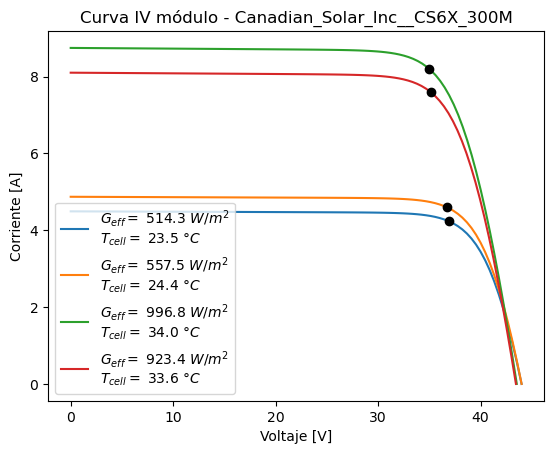

In [23]:
import matplotlib.pyplot as plt

# Graficamos las curvas IV para cada condición de operación
for idx in site_conditions.index:
    
    # Etiqueta de la curva IV
    label = ('$G_{eff}=$ %.1f $W/m^2$\n' % Geff[idx] +
            '$T_{cell}=$ %.1f $\\degree C$' % temp_cell[idx])
    
    # Gráfica de la curva IV
    plt.plot(v[:,idx], i[:,idx], label=label)
    
    # Marcamos el mpp en el gráfico
    v_mp = curve_info['v_mp'][idx] # Valor de V_mp en condiciones de operación
    i_mp = curve_info['i_mp'][idx] # Valor de I_mp en condiciones de operación
    
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k') # punto mpp

# Etiqueta de los ejes y título del gráfico
plt.xlabel('Voltaje [V]')
plt.ylabel('Corriente [A]')
plt.title('Curva IV módulo - %s' % pv_model.name)
plt.legend()
plt.show()